In [1]:
from google.colab import drive
drive.mount('/content/drive')
import re
import numpy as np # to handle NaN values

# start of regression model
import pandas as pd

# load the clean csv
df_master = pd.read_csv('/content/drive/My Drive/STA_141B_Project/master_data.csv')

# check first 5 listings
df_master.head(5)

Mounted at /content/drive


,id,post_id,price,bedrooms,bathrooms,sqft,zip_code,neighborhood,full_description,scraped_date,avg_median_income,crime_count_2025,population_2025
0,55855,7899537218,785,1.0,NaN,NaN,94115,western addition,QR Code Link to This Post\nAsk for a free appl...,2025-12-03 00:47:33,143818.92,1358,2872
1,55856,7898547059,800,2.0,1.0,NaN,94112,ingleside / SFSU / CCSF,QR Code Link to This Post\nThis is a cozy in-l...,2025-12-03 00:47:33,131280.36,1139,4762
2,55857,7899162326,800,0.0,NaN,70.0,94133,north beach / telegraph hill,QR Code Link to This Post\nSee more photos and...,2025-12-03 00:47:33,116675.28,1370,2842
3,55858,7899162301,750,0.0,NaN,120.0,94133,financial district,QR Code Link to This Post\nSee more photos and...,2025-12-03 00:47:33,116675.28,1370,2842
4,55859,7899162236,800,0.0,NaN,69.0,94133,financial district,QR Code Link to This Post\nSee more photos and...,2025-12-03 00:47:33,116675.28,1370,2842


In [2]:
def check_amenity(text_input, pattern):
    """
    Checks if a given text contains a pattern using case-insensitive search.
    Returns 1 if found, 0 if not found, and 0 if text is null.
    """
    if pd.isna(text_input) or text_input is None:
        return 0

    # re.IGNORECASE to make the search case-insensitive
    if re.search(pattern, str(text_input), re.IGNORECASE):
        return 1
    return 0

# REGEX patterns
PATTERNS = {
    'laundry': r'(laundry|w/d|washer/dryer|wash-dry)',
    'parking': r'(parking|garage|off[- ]street|offstreet)',
    'pet_friendly': r'(pet friendly|pets ok|dogs ok|cats ok)',
    'ac': r'(air conditioning|a/c|AC unit)',
    'gym': r'(gym|fitness center|rec room|workout room)'
}

DESCRIPTION_COL = 'full_description'

for amenity_name, pattern in PATTERNS.items():
    # create a new column for amenity name
    new_col_name = f'has_{amenity_name}'

    # run the check_amenity function on every row
    df_master[new_col_name] = df_master[DESCRIPTION_COL].apply(
        lambda x: check_amenity(x, pattern)
    )

    # quick check for debugging
    print(f"Created column '{new_col_name}'. Count of positive listings: {df_master[new_col_name].sum()}")

Created column 'has_laundry'. Count of positive listings: 1180
Created column 'has_parking'. Count of positive listings: 1127
Created column 'has_pet_friendly'. Count of positive listings: 429
Created column 'has_ac'. Count of positive listings: 78
Created column 'has_gym'. Count of positive listings: 335


In [3]:
# drop the large text column to free up memory
df_master.drop(columns=['full_description'], inplace=True)
df_master.head(5)

,id,post_id,price,bedrooms,bathrooms,sqft,zip_code,neighborhood,scraped_date,avg_median_income,crime_count_2025,population_2025,has_laundry,has_parking,has_pet_friendly,has_ac,has_gym
0,55855,7899537218,785,1.0,NaN,NaN,94115,western addition,2025-12-03 00:47:33,143818.92,1358,2872,0,0,0,0,0
1,55856,7898547059,800,2.0,1.0,NaN,94112,ingleside / SFSU / CCSF,2025-12-03 00:47:33,131280.36,1139,4762,1,1,0,0,0
2,55857,7899162326,800,0.0,NaN,70.0,94133,north beach / telegraph hill,2025-12-03 00:47:33,116675.28,1370,2842,0,1,0,0,0
3,55858,7899162301,750,0.0,NaN,120.0,94133,financial district,2025-12-03 00:47:33,116675.28,1370,2842,0,1,0,0,0
4,55859,7899162236,800,0.0,NaN,69.0,94133,financial district,2025-12-03 00:47:33,116675.28,1370,2842,0,1,0,0,0


# Methodology (Analysis Lead): Answering Q2 via model

In [4]:
# Building the base model for our MLR

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score

# imputing medians
bedrooms_median = df_master['bedrooms'].median()
bath_median = df_master['bathrooms'].median()
sqft_median = df_master['sqft'].median()

# imputing medians, then filling the rest with 0
df_master['bedrooms'].fillna(bedrooms_median, inplace=True)
df_master['bathrooms'].fillna(bath_median, inplace=True)
df_master['sqft'].fillna(sqft_median, inplace=True)

# Separating the explantory variable (y) and predictor variables (x) from each other. Any missing values in X is filled with 0s
X = df_master[["bedrooms", "bathrooms", "sqft", "avg_median_income", "crime_count_2025", "has_laundry", "has_parking", "has_pet_friendly", "has_ac", "has_gym"]].fillna(0)

y = df_master["price"]

# Splitting the data into training and testing, with training being 80% and testing 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)

my_model = LinearRegression() # Initializing a base model and fitting it with the training data
my_model.fit(X_train, y_train)

/tmp/ipython-input-641384638.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_master['bedrooms'].fillna(bedrooms_median, inplace=True)
/tmp/ipython-input-641384638.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

LinearRegression()

In [5]:
# Validating Base Model

y_pred_base_model = my_model.predict(X_test) # Fitting the base model by the test set

r2_base = r2_score(y_test, y_pred_base_model) # R2 base model score
mse_base = mean_squared_error(y_test, y_pred_base_model) # MSE base model score

# Since this is MLR model, adjusted r2 reflects a better performance of the model taking account of extra predictors
num_test_obs = X_test.shape[0] # number of observations from test set
num_of_predictors = X_test.shape[1] # number of predictor from the model
adj_r2_base = 1 - (1 - r2_base) * (num_test_obs - 1) / (num_test_obs - num_of_predictors - 1)

print("Adjusted R^2:", adj_r2_base)
print("MSE:", mse_base)


Adjusted R^2: 0.5619622036396958
MSE: 1092090.7072988644


In [6]:
"""
Trying to improve base model to by performing a backward feature selection using cross-validation
Starting with all predictors
Splitting into 5 folds with each fold having 1/5 for test and rest for training (4/5)
For each fold with calculate the r2, and then average the 5 r2 values from the testing fold
From this model fitted on the full set, decide what feature isn't useful, and drop that one bad feature (step = 1)
Continue with splitting of 5 folds process for this model, until we get a model with one feature
This provides a model with cv r2 scores for models with 1-5 features, and choose the best cv r2 for the best model
"""
cv = KFold(n_splits = 5, shuffle = True, random_state = 13)  # Setting up 5-fold cv
rfecv = RFECV(estimator = my_model, step = 1, cv = cv, scoring = "r2") # Initializing Recursive feature elimination cross-validation

rfecv.fit(X_train, y_train) # Running it on the training data

best_features_index = X_train.columns[rfecv.support_] # Extracting the names of features the model decided to keep, which are the best features
best_features = best_features_index.tolist() # converting to list to read
print("Best Features:", best_features)

Best Features: ['bedrooms', 'bathrooms', 'sqft', 'avg_median_income', 'crime_count_2025', 'has_laundry', 'has_parking', 'has_pet_friendly', 'has_ac', 'has_gym']


In [7]:
# Fitting new model based on new features discovered
X_best = X_train[best_features]
X_test_best = X_test[best_features]

my_best_model = LinearRegression()
my_best_model.fit(X_best, y_train)

LinearRegression()

In [8]:
# Validating the model
# Same process as earlier of valdiating model but instead of base, we use our better model

y_pred_best_model = my_best_model.predict(X_test_best)

r_sq = r2_score(y_test, y_pred_best_model)
mse = mean_squared_error(y_test, y_pred_best_model)

# Adjusted R^2
num_test_obs = X_test_best.shape[0]
num_of_predictors = X_test_best.shape[1]
adj_r2 = 1 - (1 - r_sq) * (num_test_obs - 1) / (num_test_obs - num_of_predictors - 1)

print("Adjusted R^2:", adj_r2)
print("MSE:", mse)

Adjusted R^2: 0.5619622036396958
MSE: 1092090.7072988644


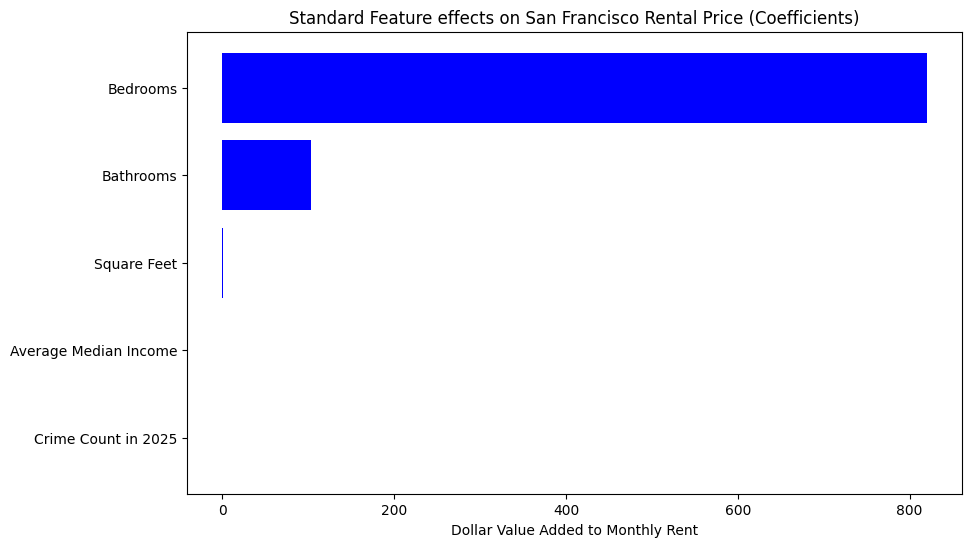

In [9]:
import matplotlib.pyplot as plt
# Coefficient Bar Chart (only standard features)

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": my_model.coef_
})

RENAME_MAP = {
    'bedrooms': 'Bedrooms',
    'bathrooms': 'Bathrooms',
    'sqft': 'Square Feet',
    'avg_median_income': 'Average Median Income',
    'crime_count_2025': 'Crime Count in 2025'
}

# apply the renaming to the 'Feature' column
coef_df['Feature'] = coef_df['Feature'].replace(RENAME_MAP)

# only selecting standard for graph
FEATURES_TO_PLOT = [
    'Bedrooms',
    'Bathrooms',
    'Square Feet',
    'Average Median Income',
    'Crime Count in 2025'
]

# final plot filtered to standard features
df_final_plot = coef_df[coef_df['Feature'].isin(FEATURES_TO_PLOT)]

# sort the remaining data by coefficient value for a clean plot
df_final_plot = df_final_plot.sort_values(by='Coefficient', ascending=False)

# ploting the results
plt.figure(figsize=(10, 6))
plt.barh(df_final_plot['Feature'], df_final_plot['Coefficient'],
         color=['red' if c < 0 else 'blue' for c in df_final_plot['Coefficient']])
plt.xlabel("Dollar Value Added to Monthly Rent")
plt.title("Standard Feature effects on San Francisco Rental Price (Coefficients)")
plt.gca().invert_yaxis() # keep the highest value on top
plt.show()

In [10]:
# Answering Q2: Dollar Value Per Ammenity

# From our best features all five ammenties appeared in our final model
final_ammenties = ["has_laundry", "has_parking", "has_pet_friendly", "has_ac", "has_gym"]

# Runnning a loop for each ammentity in the list to extract the coefficients in order to see dollar value it contributes to in price
coefficients_amenity = []
for ammenity in final_ammenties:
    coefficients = my_best_model.coef_[best_features.index(ammenity)] # Finding the position of the ammentity and then the pulling the matching coefficient from my_best_model.coef
    print(f"Dollar Value Per {ammenity}: ${coefficients:.0f} per month")
    coefficients_amenity.append(coefficients)
#

Dollar Value Per has_laundry: $4 per month
Dollar Value Per has_parking: $64 per month
Dollar Value Per has_pet_friendly: $143 per month
Dollar Value Per has_ac: $520 per month
Dollar Value Per has_gym: $369 per month


After controlling for variables such as bedrooms, bathrooms, sqft, average median income, and crime_count_2025, we are able to see what each ammentiy contributes to an increase dollar amount per month in rent.

* Highest added dollar value: has_ac is 520 dollars per month

* Least added dollar value: has_laundry is 4 dollars per month

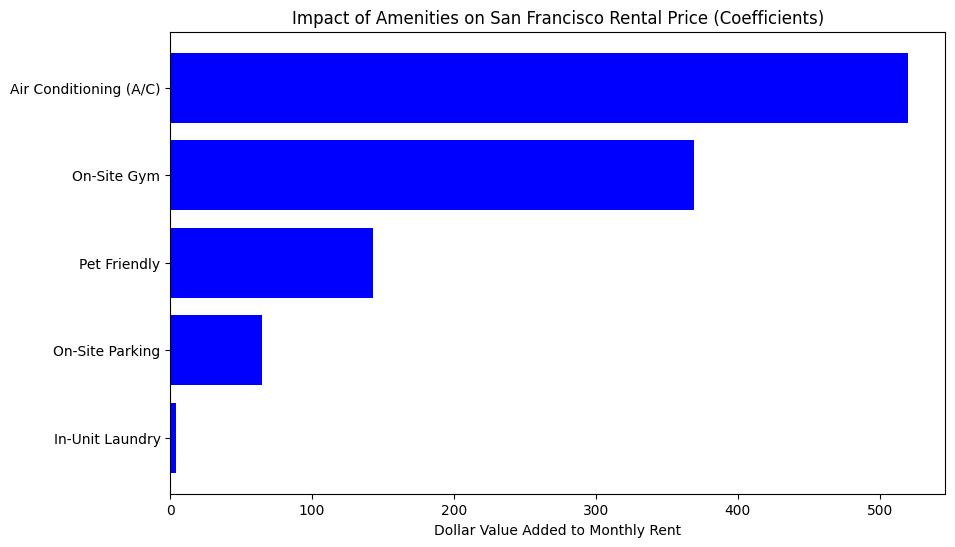

In [11]:
### COEF PLOT
import matplotlib.pyplot as plt


# create a DataFrame to plot and sort
df_coef = pd.DataFrame({
    'Feature': final_ammenties,
    'Coefficient': coefficients_amenity
})

# mapping of amenity names to display names
RENAME_MAP = {
    'has_laundry': 'In-Unit Laundry',
    'has_parking': 'On-Site Parking',
    'has_pet_friendly': 'Pet Friendly',
    'has_ac': 'Air Conditioning (A/C)',
    'has_gym': 'On-Site Gym'
}

# apply the renaming to the 'Feature' column
df_coef['Feature'] = df_coef['Feature'].replace(RENAME_MAP)

# only selecting amenities for graph
FEATURES_TO_PLOT = [
    'In-Unit Laundry',
    'On-Site Parking',
    'Pet Friendly',
    'Air Conditioning (A/C)',
    'On-Site Gym'
]

# final plot filtered to amenities
df_final_plot = df_coef[df_coef['Feature'].isin(FEATURES_TO_PLOT)]

# sort the remaining data by coefficient value for a clean plot
df_final_plot = df_final_plot.sort_values(by='Coefficient', ascending=False)

# ploting the results
plt.figure(figsize=(10, 6))
plt.barh(df_final_plot['Feature'], df_final_plot['Coefficient'],
         color=['red' if c < 0 else 'blue' for c in df_final_plot['Coefficient']])
plt.xlabel("Dollar Value Added to Monthly Rent")
plt.title("Impact of Amenities on San Francisco Rental Price (Coefficients)")
plt.gca().invert_yaxis() # keep the highest value on top
plt.show()

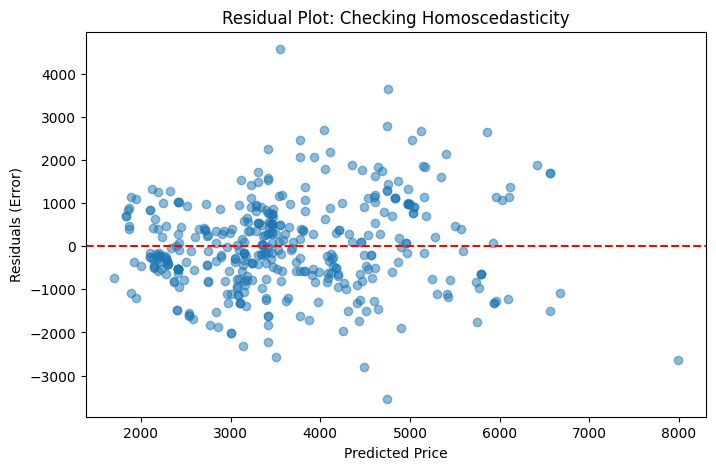

In [12]:
### RESID PLOT
# calculating the residuals (Actual Y - Predicted Y)
residuals = y_test - y_pred_best_model

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_best_model, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--') # Line at error = 0
plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot: Checking Homoscedasticity")
plt.show()

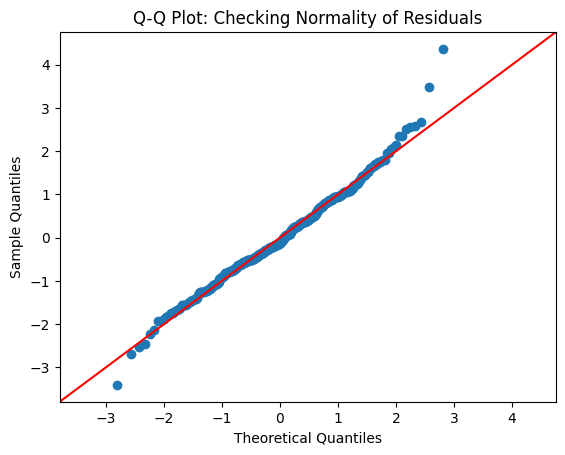

In [13]:
import statsmodels.api as sm

# sm.qqplot to plot residuals against the standard normal distribution
fig = sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot: Checking Normality of Residuals")
plt.show()